<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Variables" data-toc-modified-id="Set-Variables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Variables</a></span></li><li><span><a href="#Pulling-data-&amp;-EDA" data-toc-modified-id="Pulling-data-&amp;-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pulling data &amp; EDA</a></span><ul class="toc-item"><li><span><a href="#json-files" data-toc-modified-id="json-files-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>json files</a></span></li><li><span><a href="#horizon-file" data-toc-modified-id="horizon-file-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>horizon file</a></span></li><li><span><a href="#get-data" data-toc-modified-id="get-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>get data</a></span></li><li><span><a href="#1-hour-price-and-trades" data-toc-modified-id="1-hour-price-and-trades-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>1 hour price and trades</a></span></li><li><span><a href="#joined_data" data-toc-modified-id="joined_data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>joined_data</a></span></li><li><span><a href="#Agg-markout" data-toc-modified-id="Agg-markout-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Agg markout</a></span></li></ul></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Short-answers" data-toc-modified-id="Short-answers-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Short answers</a></span><ul class="toc-item"><li><span><a href="#maker-taker?" data-toc-modified-id="maker-taker?-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>maker taker?</a></span></li><li><span><a href="#other-characteristics" data-toc-modified-id="other-characteristics-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>other characteristics</a></span></li><li><span><a href="#drawdown" data-toc-modified-id="drawdown-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>drawdown</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pprint

pd.set_option('display.precision', 10)

# Set Variables

In [2]:
# specify 1hour period
start_time = pd.Timestamp("2023-04-30 23:15:00")
end_time = start_time + pd.Timedelta(minutes=60)

print(start_time, end_time)

2023-04-30 23:15:00 2023-05-01 00:15:00


# Pulling data & EDA

## json files

In [3]:
file_names = [
    'BTAUSD.json'
]

meta_data = {}

for file_name in file_names:
    with open (file_name, 'r') as file:
        key = file_name.split('.')[0]
        meta_data[key]=json.load(file)

## horizon file

In [4]:
with open('horizon_ticks', 'r') as file:
    horizon_arr = np.array(json.load(file))

## get data

In [5]:
def get_md_and_trade_data(instrument):
    """get market data and trade data"""
    
    md = pd.read_csv(f'{instrument}_md.csv', index_col = 0)
    md=md.sort_index()
    
    trades = pd.read_csv(f'{instrument}_trades.csv', index_col = 0)
    trades=trades.sort_index()
        
    return md, trades

In [6]:
def get_interval_data(md, trades):
    """ slice to obtain information within specified time range"""
    md_interval = md.copy()
    md_interval.index = pd.to_datetime(md_interval.index, unit='ms')
    md_interval = md_interval.loc[start_time : end_time]
    
    trades_interval=trades.copy().sort_index()
    trades_interval.index = pd.to_datetime(trades_interval.index, unit='ms')
    trades_interval = trades_interval.loc[start_time : end_time]
    
    return md_interval, trades_interval

## 1 hour price and trades

In [7]:
def plot_interval(symbol, md_interval, trades_interval, start, end):
    """plot price and trade info within specified time range"""
    
    fig, ax = plt.subplots(figsize=(16,10))

    ax.plot(md_interval.index,
           md_interval.bid, 
            linewidth=1,
           label ='bid')

    ax.plot(md_interval.index,
           md_interval.ask,
           linewidth=1,
           label='ask')

    buy_mask = trades_interval['side']=='B'
    ax.plot(trades_interval.loc[buy_mask].index,
            trades_interval[buy_mask].px,
            '^',
            color='green',
            markersize=8,
           label='buy')

    sell_mask = trades_interval['side']=='S'
    ax.plot(trades_interval.loc[sell_mask].index,
            trades_interval[sell_mask].px,
            'v',
            color='red',
            markersize=8,
           label='sell')

    ax.set_title(f"{symbol} Price and Trades between {start} and {end}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    ax.legend()
    plt.show()

## joined_data

In [8]:
def cal_margin(md, trades):
    """compute PnL and margin"""
    
    joined_data = md.join(trades, how='outer')
    joined_data.sort_index(inplace=True)
    joined_data['mid'] = 0.5*joined_data['bid'] + 0.5*joined_data['ask']
    joined_data['mid']=joined_data['mid'].ffill()

    joined_data['side_vector']=np.where(joined_data['side']=='B', 1, 0)
    joined_data['side_vector']=np.where(joined_data['side']=='S', -1, joined_data['side_vector'])

    joined_data['trade_pos']=joined_data['side_vector']*joined_data['size']
#     joined_data['trade_pos'] = joined_data['trade_pos'].ffill()
    joined_data['trade_pos'] = joined_data['trade_pos'].fillna(0)
    
    joined_data['cumu_pos']=joined_data['trade_pos'].cumsum()
    joined_data['cumu_pos'] = joined_data['cumu_pos'].ffill()
    joined_data['mtm_unrealized_pnl'] = joined_data['mid']*joined_data['cumu_pos']
    
    joined_data['trade_effect_on_fund'] = -joined_data['px']*joined_data['trade_pos']
    joined_data['trade_effect_on_fund'] = joined_data['trade_effect_on_fund'].fillna(0)
    joined_data['realized_pnl']=joined_data['trade_effect_on_fund'].cumsum()
    joined_data['PnL']=joined_data['mtm_unrealized_pnl']+joined_data['realized_pnl']
    
    
    joined_data['trade_volume'] = joined_data['size'].abs() * joined_data['px']
    joined_data['trade_volume'] = joined_data['trade_volume'].fillna(0)
    joined_data['cumu_trade_volume'] = joined_data['trade_volume'].cumsum()
    joined_data['margin']=joined_data['PnL']/joined_data['cumu_trade_volume']
    joined_data['margin']=joined_data['margin'].fillna(0)

    return joined_data

In [9]:
def plot_pnl(joined_data):
    joined_data[['PnL']].plot(figsize=(16,10),
                                     title = 'PnL (unrealized MTM & realized)',
                                    xlabel = 'timestamp',
                                    ylabel = 'USD PnL',
                                    )

## Agg markout

In [10]:
def plot_agg_markout(df_ori):
    df=df_ori.copy()
    """ plot margin markout """
    
    # use mid as market price
    df.index = df.index.view('int64') // 10**6
    price_times = df.index.values
    price_values = df['mid'].values

    # Extract trade data
    trades = df[df['trade_id'].notnull()].copy()
    trade_times = trades.index.values.astype(np.int64)
    trade_ids = trades['trade_id'].values
    trade_sides = trades['side_vector'].values
    trade_prices = trades['px'].values

    # Compute a (n_trades x n_horizons) matrix of future times for each trade.
    # Each element = trade time + horizon.
    future_times = trade_times[:, None] + horizon_arr[None, :]

    # Use np.searchsorted on the sorted margin_times to find the margin as-of each future time.
    indices = np.searchsorted(price_times, future_times)

    # Clip indices to valid range (if future time goes beyond available margin data).
    indices_clipped = np.clip(indices, 0, len(price_times) - 1)
    future_prices = price_values[indices_clipped]

    # Set future prices to NaN where the future time was out of bounds.
    future_prices[indices >= len(price_times)] = np.nan
    
    """ Calculate markout margin as side *(horizon price - trade price)"""
    margins = trade_sides[:, None] * (future_prices - trade_prices[:, None])
    margin_df = pd.DataFrame(margins, index=trade_ids, columns=horizon_arr)
    final_margin_df = margin_df.T
    
    # Compute the aggregate margin as the simple average across trades at each horizon.
    x = final_margin_df.index.values
    mean_series = np.mean(final_margin_df, axis=1)
    std_series = np.std(final_margin_df, axis=1)
    
    plt.figure()
    plt.plot(x, mean_series, label='Mean', color='blue')
    plt.fill_between(x, mean_series - std_series, mean_series + std_series, color='blue', alpha=0.3, label='±1 Std Dev')
    plt.xticks(rotation=45)
    plt.title('Aggregate Markout Curve with 1sd overlay')
    plt.xlabel('Horizon (ms)')
    plt.ylabel('Aggregate Margin')
    plt.legend()
    plt.show()
    
    
    """assume all trades are buy, for alternative insights"""
    margins_2 = (future_prices - trade_prices[:, None])
    margins_2 = pd.DataFrame(margins_2, index=trade_ids, columns=horizon_arr)
    final_margin_df2 = margins_2.T
    
    # Compute the aggregate margin as the simple average across trades at each horizon.
    x2 = final_margin_df2.index.values
    mean_series2 = np.mean(final_margin_df2, axis=1)
    std_series2 = np.std(final_margin_df2, axis=1)
    
    plt.figure()
    plt.plot(x2, mean_series2, label='Mean', color='blue')
    plt.fill_between(x2, mean_series2 - std_series2, mean_series2 + std_series2, color='blue', alpha=0.3, label='±1 Std Dev')
    plt.xticks(rotation=45)
    plt.title('Aggregate Markout Curve with 1sd overlay (assume all buy)')
    plt.xlabel('Horizon (ms)')
    plt.ylabel('Aggregate Margin')
    plt.legend()
    plt.show()
    
    return final_margin_df

# Output

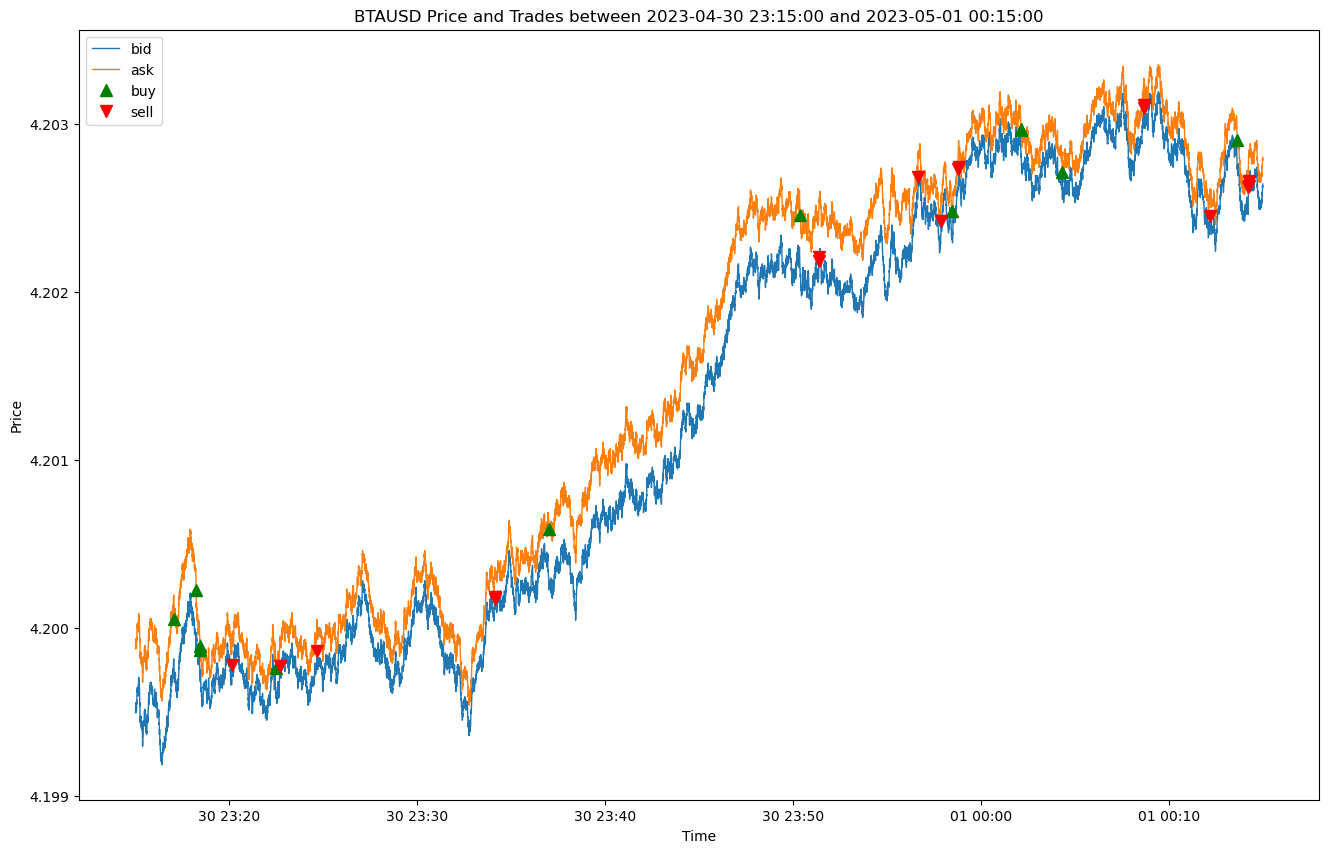

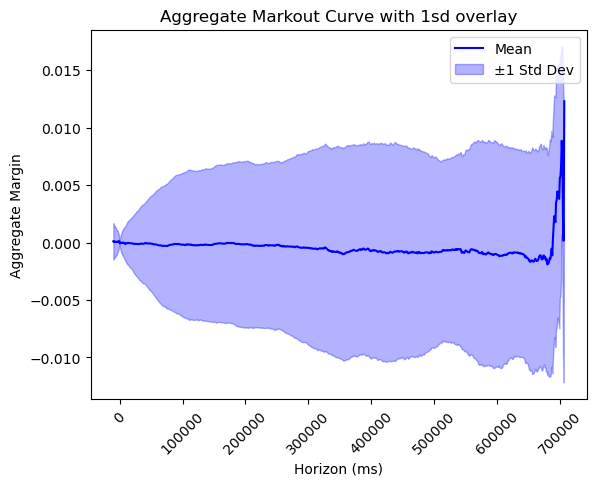

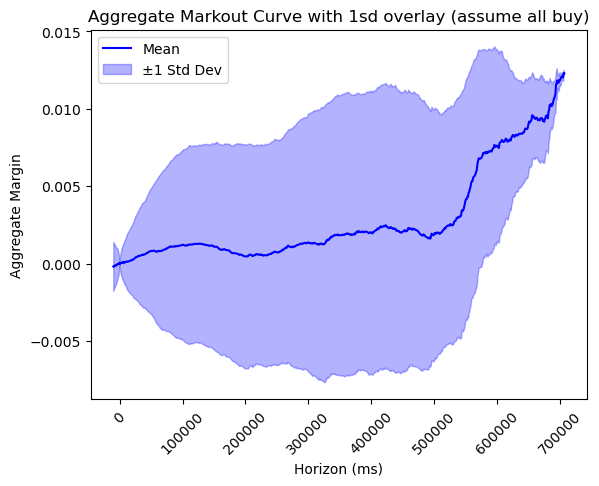

In [11]:
joined_data_dic = {}

for instrument, details in meta_data.items():
    md, trades = get_md_and_trade_data(instrument)
    df_md_1hr, df_trades_1hr = get_interval_data(md, trades)
    plot_interval(instrument, df_md_1hr, df_trades_1hr, start_time, end_time)
    joined_data = cal_margin(md, trades)
    plot_agg_markout(joined_data)
    
    joined_data_dic[instrument]=joined_data

# Short answers

## maker taker?

In [12]:
for instrument, details in meta_data.items():
    joined_data = joined_data_dic[instrument]

    # simple approach using mid price
    condition = [
    (joined_data['side']=='B') & (joined_data['px']>=joined_data['mid']),
    (joined_data['side']=='B') & (joined_data['px']<joined_data['mid']),
    (joined_data['side']=='S') & (joined_data['px']<=joined_data['mid']),
    (joined_data['side']=='S') & (joined_data['px']>joined_data['mid']),
    ]

    choice = [
        'Taker',
        'Maker',
        'Taker',
        'Maker'
    ]

    joined_data['make/take'] = np.select(condition, choice, default= 'not_a_trade')
    summary = joined_data['make/take'].value_counts()
    filterted_summary = summary.drop('not_a_trade')
    if 'Maker' in  filterted_summary and 'Taker' in filterted_summary:
        if filerted_summary['Maker']> filerted_summary['Taker']:
            print(f"{instrument} strategy is a Maker")
        elif filerted_summary['Maker']< filerted_summary['Taker']:
            print(f"{instrument} strategy is a Taker")
    elif 'Maker' in filterted_summary:
        print(f"{instrument} strategy is a Maker")
    elif 'Taker' in filterted_summary:
        print(f"{instrument} strategy is a Taker")
    else:
        print('strat unsure')

BTAUSD strategy is a Taker


## other characteristics

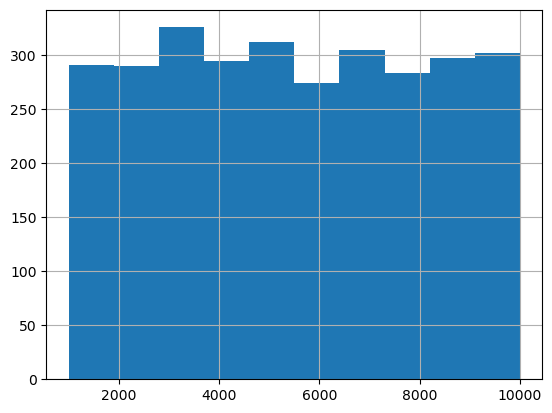

In [13]:
for instrument, details in meta_data.items():  
    df_md, df_trades = get_md_and_trade_data(instrument)
    df_trades['size'].hist()
    
    plt.show()

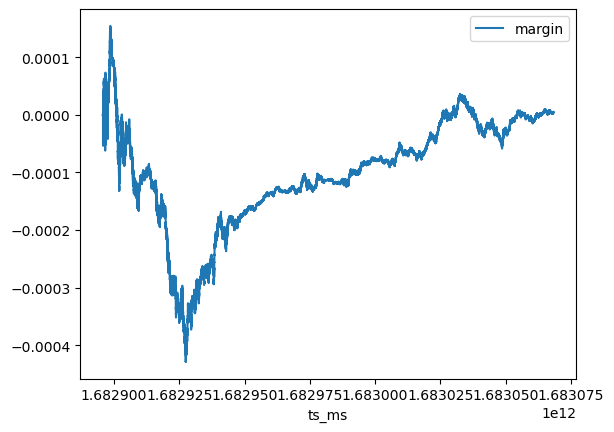

In [14]:
for instrument, details in meta_data.items():  
    df = joined_data_dic[instrument]
    df[['margin']].plot()
    plt.show()
    
    plt.show()

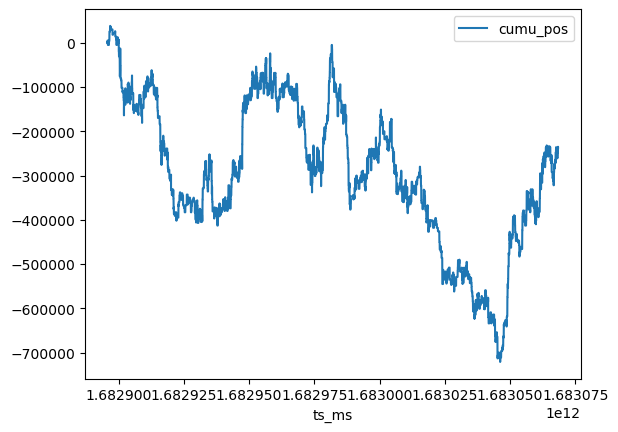

In [15]:
for instrument, details in meta_data.items():
    df = joined_data_dic[instrument]
    df[['cumu_pos']].plot()
    plt.show()


## drawdown

MDD for BTAUSD is -5471.96, on 2023-05-02 17:30:52


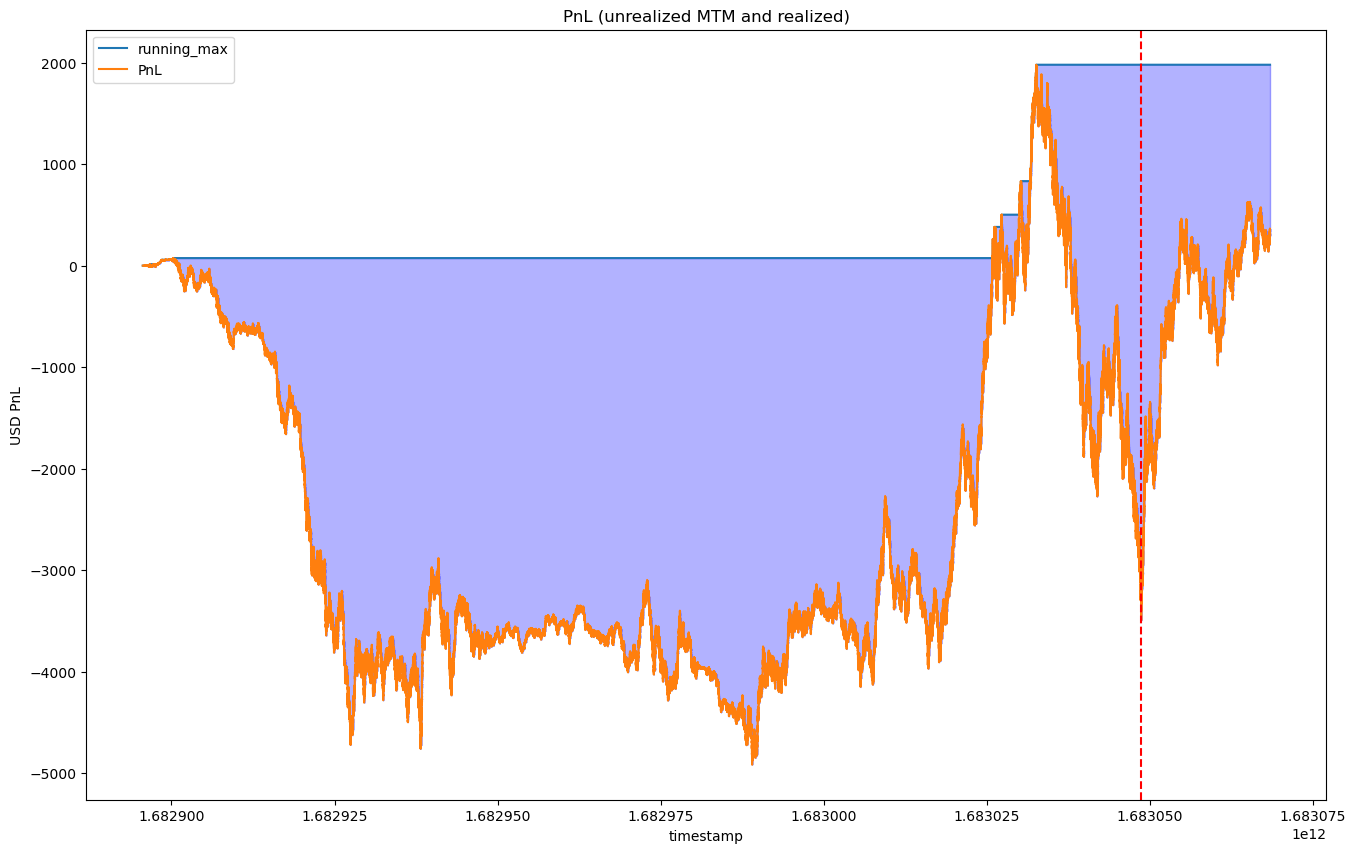

In [16]:
from datetime import datetime
for instrument, details in meta_data.items():
    df = joined_data_dic[instrument]
    df['running_max']=df['PnL'].cummax()
    df['drawdown'] = df['PnL'] - df['running_max']
    max_drawdown = df['drawdown'].min()
    drawdown_idx = df['drawdown'].idxmin()
    mdd_time = pd.to_datetime(drawdown_idx, unit='ms')

    df[['running_max', 'PnL']].plot(
                                         title = 'PnL (unrealized MTM and realized)',
                                        xlabel = 'timestamp',
                                        ylabel = 'USD PnL',
                                        figsize=(16,10))
    
    plt.fill_between(df.index, df['running_max'], df['PnL'], color='blue', alpha=0.3, label='±1 Std Dev')
    plt.axvline(x=drawdown_idx, color='r', linestyle ='--')

    print(f"MDD for {instrument} is {max_drawdown:.2f}, on {mdd_time}")